In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
# reading input data 

with open('../datasets/question_titles_vec.pickle', 'rb') as f:
    X_t = pickle.load(f)
    
with open('../datasets/questions_vec.pickle', 'rb') as f:
    X_q = pickle.load(f)
    
with open('../datasets/answers_vec.pickle', 'rb') as f:
    X_a = pickle.load(f)

In [3]:
X_t.shape, X_q.shape, X_a.shape

((6076, 32, 300), (6076, 500, 300), (6076, 500, 300))

In [4]:
data = pd.read_pickle('../datasets/train_processed.pickle')

In [5]:
target_names = data.columns[3:-3].copy()

y = data[data.columns[3:-3]].values.copy()
y.shape

(6076, 30)

In [6]:
# train test split
from sklearn.model_selection import train_test_split

X_t_train, X_t_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)
X_q_train, X_q_test, y_train, y_test = train_test_split(X_q, y, test_size=0.2, random_state=42)
X_a_train, X_a_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

In [7]:
X_q_train.shape

(4860, 500, 300)

# Utility functions

In [8]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error as mse

def print_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        name = target_names[i]
        name = name + ':'
        if len(name)<40:
            name = name + ' '*(40-len(name))
        print(name, f'cor: {np.round(spearmanr(preds[:,i],reals[:,i]).correlation,3)},    mse: {np.round(mse(preds[:,i],reals[:,i]),3)}')
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    print('\n\n CORRELATION STATS: \n', pd.Series(cors).describe())
    print('\n\n MSE STATS: \n', pd.Series(mses).describe())

In [9]:
def plot_cors_mse(target_names, preds, reals):
    cors = []
    mses = []
    for i in range(len(target_names)):
        cors.append(spearmanr(preds[:,i],reals[:,i]).correlation)
        mses.append(mse(preds[:,i],reals[:,i]))
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.bar(target_names, cors)
    plt.xticks(rotation=90)
    plt.title('CORS')
    plt.subplot(1,2,2)
    plt.bar(target_names, mses)
    plt.xticks(rotation=90)
    plt.title('MSEs')

In [10]:
# scatterplots

def scatterplots(target_names, preds, reals):
    plt.figure(figsize=(25,35))
    for i in range(len(target_names)):
        plt.subplot(10,3,i+1)
        plt.scatter(preds[:,i],reals[:,i])
        plt.title(target_names[i])
        plt.tight_layout()
    plt.show()

In [11]:
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, restore_best_weights=True)

In [12]:
import tensorflow.keras.backend as K

class attention_many_to_one(keras.layers.Layer):

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        #super().build(input_shape)

    def call(self,x):
        # like time-distributed dense
        # each time point has n features
        # takes dot of features with weights (weights have dim n)
        # returns vector of len t - for each timepoint, just one value is returned
        # squeezed from (t,1) to t
        dots=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        softmax_weights=K.softmax(dots)
        softmax_weights=K.expand_dims(softmax_weights,axis=-1)
        # each time point is miltiplied by corresponding scalar
        # this gives greater weight to more important words in output sequence
        output=x*softmax_weights
        # all t time ponts are summed to get just one vector of dim n
        return K.sum(output,axis=1)

# Model

In [13]:
# titles

input_t = keras.layers.Input(shape=(32,300))
# self attention
x_t_att = keras.layers.Attention()([input_t,input_t])
x_t_att = keras.layers.BatchNormalization()(x_t_att)
# concatenate original and attention embedding
x_t = keras.layers.concatenate([input_t, x_t_att], axis=-1)
# lstm
x_t = keras.layers.Masking()(x_t)
x_t = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_t)
# attention many to one
x_t_1 = attention_many_to_one()(x_t)
x_t_1 = keras.layers.BatchNormalization()(x_t_1)
# last lstm output
x_t = x_t[:,-1,:]
# concatenating 
x_t = keras.layers.concatenate([x_t,x_t_1])
x_t = keras.layers.Dropout(0.3)(x_t)
x_t = keras.layers.Dense(30, activity_regularizer='l2', activation=keras.activations.swish)(x_t)


# questions

input_q = keras.layers.Input(shape=(500,300))
# self attention
x_q_att = keras.layers.Attention()([input_q,input_q])
x_q_att = keras.layers.BatchNormalization()(x_q_att)
# concatenate original and attention embedding
x_q = keras.layers.concatenate([input_q, x_q_att], axis=-1)
# lstm
x_q = keras.layers.Masking()(x_q)
x_q = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True,  return_state=True, activity_regularizer='l2'))(x_q)
# last hidden and cell states to feed to answers
s_q = x_q[1:]
x_q = x_q[0]
# attention may to one
x_q_1 = attention_many_to_one()(x_q)
x_q_1 = keras.layers.BatchNormalization()(x_q_1)
# last lstm output
x_q = x_q[:,-1,:]
# concatenating
x_q = keras.layers.concatenate([x_q,x_q_1])
x_q = keras.layers.Dropout(0.3)(x_q)
x_q = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_q)


# answers

input_a = keras.layers.Input(shape=(500,300))
# self attention
x_a_att = keras.layers.Attention()([input_a,input_a])
x_a_att = keras.layers.BatchNormalization()(x_a_att)
# concatenate original and attention embedding
x_a = keras.layers.concatenate([input_t, x_t_att], axis=-1)
# lstm
x_a = keras.layers.Masking()(x_a)
x_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_a, initial_state=s_q)
# attention many to one
x_a_1 = attention_many_to_one()(x_a)
x_a_1 = keras.layers.BatchNormalization()(x_a_1)
# last lstm output
x_a = x_a[:,-1,:]
# concatenating
x_a = keras.layers.concatenate([x_a,x_a_1])
x_a = keras.layers.Dropout(0.3)(x_a)
x_a = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_a)


# questions-answers

# questions - answers attention
x_q_a_att = keras.layers.Attention()([input_q,input_a])
x_q_a_att = keras.layers.BatchNormalization()(x_q_a_att)
# concatenate original question, answer and attention embeddings
x_q_a = keras.layers.concatenate([input_q, input_a, x_a_att], axis=-1)
# lstm
x_q_a = keras.layers.Masking()(x_q_a)
x_q_a = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.3, return_sequences=True, activity_regularizer='l2'))(x_q_a)
# attention many to one
x_q_a_1 = attention_many_to_one()(x_q_a)
x_q_a_1 = keras.layers.BatchNormalization()(x_q_a_1)
# last lstm output
x_q_a = x_q_a[:,-1,:]
# concatenating
x_q_a = keras.layers.concatenate([x_q_a, x_q_a_1])
x_q_a = keras.layers.Dropout(0.3)(x_q_a)
x_q_a = keras.layers.Dense(100, activity_regularizer='l2', activation=keras.activations.swish)(x_q_a)


# concat all 
x = keras.layers.concatenate((x_t, x_q, x_a, x_q_a))

x = keras.layers.BatchNormalization(name='last_batch_normalization')(x)

output = keras.layers.Dense(30, activation='sigmoid')(x)

model = keras.Model([input_t, input_q, input_a], output)

model.compile(optimizer = 'adam', loss = 'mse')

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 300)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 32, 300)]    0                                            
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 500, 300)     0           input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 500, 300)]   0                                 

In [15]:
history = model.fit([X_t_train, X_q_train, X_a_train], y_train, batch_size=50, epochs=500, callbacks=[earlystopping], validation_data=([X_t_test, X_q_test, X_a_test], y_test))

Epoch 1/500
98/98 [==============================] - 46s 472ms/step - loss: 10.8467 - val_loss: 0.3058
Epoch 2/500
98/98 [==============================] - 39s 399ms/step - loss: 1.8732 - val_loss: 0.1336
Epoch 3/500
98/98 [==============================] - 39s 400ms/step - loss: 0.6791 - val_loss: 0.0913
Epoch 4/500
98/98 [==============================] - 39s 398ms/step - loss: 0.3144 - val_loss: 0.0776
Epoch 5/500
98/98 [==============================] - 39s 400ms/step - loss: 0.1841 - val_loss: 0.0710
Epoch 6/500
98/98 [==============================] - 39s 400ms/step - loss: 0.1281 - val_loss: 0.0652
Epoch 7/500
98/98 [==============================] - 39s 400ms/step - loss: 0.0985 - val_loss: 0.0593
Epoch 8/500
98/98 [==============================] - 39s 401ms/step - loss: 0.0827 - val_loss: 0.0560
Epoch 9/500
98/98 [==============================] - 39s 400ms/step - loss: 0.0723 - val_loss: 0.0533
Epoch 10/500
98/98 [==============================] - 39s 401ms/step - loss: 0.06

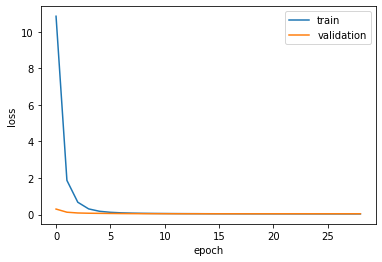

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [17]:
model.save_weights('models/final_model_weights_lstm_att_comb_2.h5')

In [15]:
model.load_weights('models/final_model_weights_lstm_att_comb.h5')

In [18]:
preds_train = model.predict([X_t_train, X_q_train, X_a_train])
preds_test = model.predict([X_t_test, X_q_test, X_a_test])

In [17]:
print_cors_mse(target_names, preds_test, y_test)

question_asker_intent_understanding:     cor: 0.325,    mse: 0.016
question_body_critical:                  cor: 0.589,    mse: 0.032
question_conversational:                 cor: 0.389,    mse: 0.027
question_expect_short_answer:            cor: 0.203,    mse: 0.127
question_fact_seeking:                   cor: 0.286,    mse: 0.081
question_has_commonly_accepted_answer:   cor: 0.373,    mse: 0.088
question_interestingness_others:         cor: 0.363,    mse: 0.017
question_interestingness_self:           cor: 0.441,    mse: 0.028
question_multi_intent:                   cor: 0.444,    mse: 0.094
question_not_really_a_question:          cor: 0.019,    mse: 0.002
question_opinion_seeking:                cor: 0.394,    mse: 0.117
question_type_choice:                    cor: 0.53,    mse: 0.096
question_type_compare:                   cor: 0.297,    mse: 0.02
question_type_consequence:               cor: 0.041,    mse: 0.005
question_type_definition:                cor: 0.318,    mse: 0.0

In [18]:
print_cors_mse(target_names, preds_train, y_train)

question_asker_intent_understanding:     cor: 0.437,    mse: 0.015
question_body_critical:                  cor: 0.723,    mse: 0.024
question_conversational:                 cor: 0.42,    mse: 0.018
question_expect_short_answer:            cor: 0.479,    mse: 0.094
question_fact_seeking:                   cor: 0.523,    mse: 0.06
question_has_commonly_accepted_answer:   cor: 0.524,    mse: 0.062
question_interestingness_others:         cor: 0.439,    mse: 0.015
question_interestingness_self:           cor: 0.588,    mse: 0.022
question_multi_intent:                   cor: 0.622,    mse: 0.062
question_not_really_a_question:          cor: 0.029,    mse: 0.002
question_opinion_seeking:                cor: 0.608,    mse: 0.086
question_type_choice:                    cor: 0.67,    mse: 0.066
question_type_compare:                   cor: 0.316,    mse: 0.011
question_type_consequence:               cor: 0.137,    mse: 0.005
question_type_definition:                cor: 0.339,    mse: 0.00

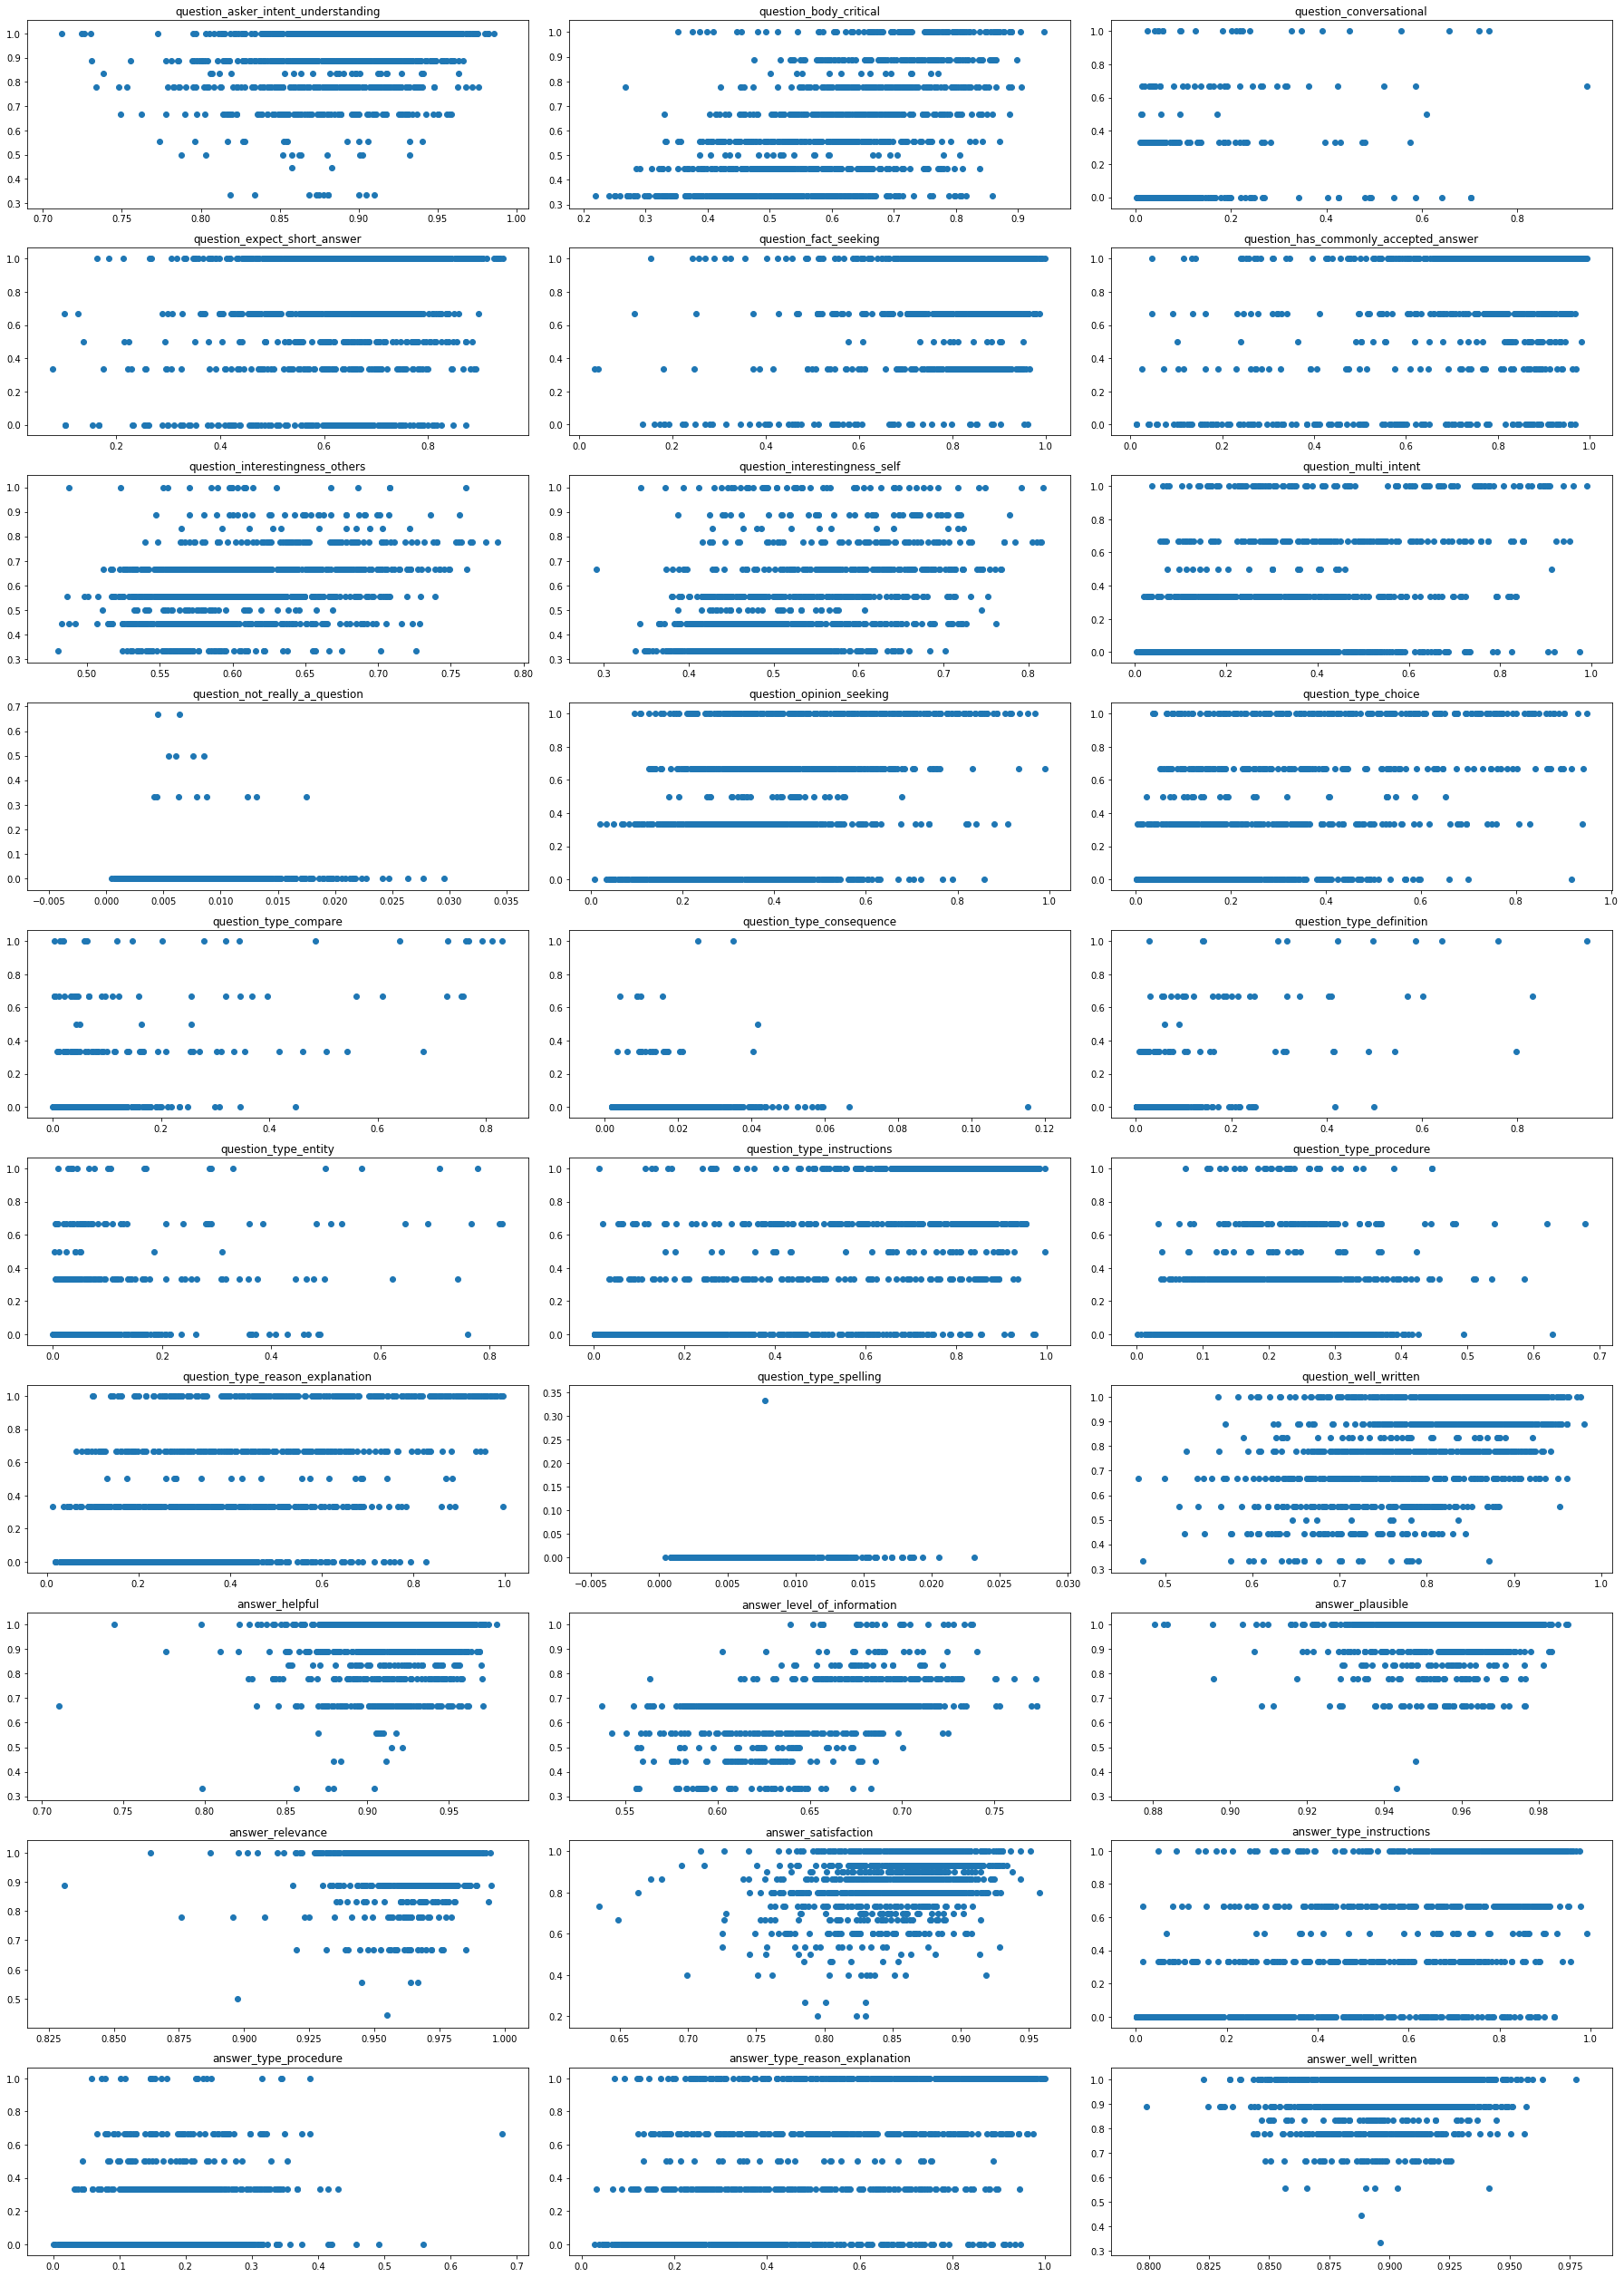

In [19]:
scatterplots(target_names, preds_test, y_test)

In [20]:
from lightgbm import LGBMRegressor

reg = LGBMRegressor(n_jobs=-1, min_child_samples=20)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse

scorer = make_scorer(mse, greater_is_better=False)

rs = RandomizedSearchCV(estimator=reg, 
                        param_distributions={'learning_rate':[0.1,0.05, 0.01, 0.005, 0.001],
                                                            'n_estimators':[100,500,1000],
                                                            'reg_alpha':[0,0.05,0.1,0.5,1,2,5,10,50],
                                                            'max_depth':[4,None]},
                       n_iter=10,
                       scoring=scorer,
                       n_jobs=-1,
                       refit=True, 
                        cv=5)

In [21]:
model2 = keras.models.Model(model.input, model.get_layer('last_batch_normalization').output)

In [22]:
X_train_rf = model2.predict([X_t_train, X_q_train, X_a_train])
X_test_rf = model2.predict([X_t_test, X_q_test, X_a_test])

In [23]:
preds_rf_train = []
preds_rf_test = []

for i in range(len(target_names)):
    
    y = y_train[:,i]
    
    rs.fit(X_train_rf, y)
    
    reg = rs.best_estimator_
    
    path = 'models/' + target_names[i] + '_model.pickle'
    with open(path, 'wb') as f:
        pickle.dump(reg, f)

    preds_rf_train.append(reg.predict(X_train_rf))
    preds_rf_test.append(reg.predict(X_test_rf))
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [24]:
preds_rf_train = np.array(preds_rf_train)
preds_rf_train = preds_rf_train.T

preds_rf_test = np.array(preds_rf_test)
preds_rf_test = preds_rf_test.T

In [25]:
print_cors_mse(target_names, preds_rf_test, y_test)

question_asker_intent_understanding:     cor: 0.32,    mse: 0.016
question_body_critical:                  cor: 0.603,    mse: 0.03
question_conversational:                 cor: 0.415,    mse: 0.025
question_expect_short_answer:            cor: 0.211,    mse: 0.124
question_fact_seeking:                   cor: 0.3,    mse: 0.08
question_has_commonly_accepted_answer:   cor: 0.365,    mse: 0.087
question_interestingness_others:         cor: 0.347,    mse: 0.017
question_interestingness_self:           cor: 0.449,    mse: 0.028
question_multi_intent:                   cor: 0.451,    mse: 0.09
question_not_really_a_question:          cor: 0.037,    mse: 0.002
question_opinion_seeking:                cor: 0.391,    mse: 0.115
question_type_choice:                    cor: 0.57,    mse: 0.089
question_type_compare:                   cor: 0.319,    mse: 0.021
question_type_consequence:               cor: 0.106,    mse: 0.005
question_type_definition:                cor: 0.312,    mse: 0.013
qu

In [26]:
print_cors_mse(target_names, preds_rf_train, y_train)

question_asker_intent_understanding:     cor: 0.639,    mse: 0.011
question_body_critical:                  cor: 0.805,    mse: 0.017
question_conversational:                 cor: 0.48,    mse: 0.013
question_expect_short_answer:            cor: 0.679,    mse: 0.068
question_fact_seeking:                   cor: 0.768,    mse: 0.033
question_has_commonly_accepted_answer:   cor: 0.654,    mse: 0.048
question_interestingness_others:         cor: 0.745,    mse: 0.009
question_interestingness_self:           cor: 0.779,    mse: 0.013
question_multi_intent:                   cor: 0.777,    mse: 0.034
question_not_really_a_question:          cor: 0.176,    mse: 0.002
question_opinion_seeking:                cor: 0.748,    mse: 0.062
question_type_choice:                    cor: 0.847,    mse: 0.027
question_type_compare:                   cor: 0.419,    mse: 0.006
question_type_consequence:               cor: 0.253,    mse: 0.002
question_type_definition:                cor: 0.394,    mse: 0.

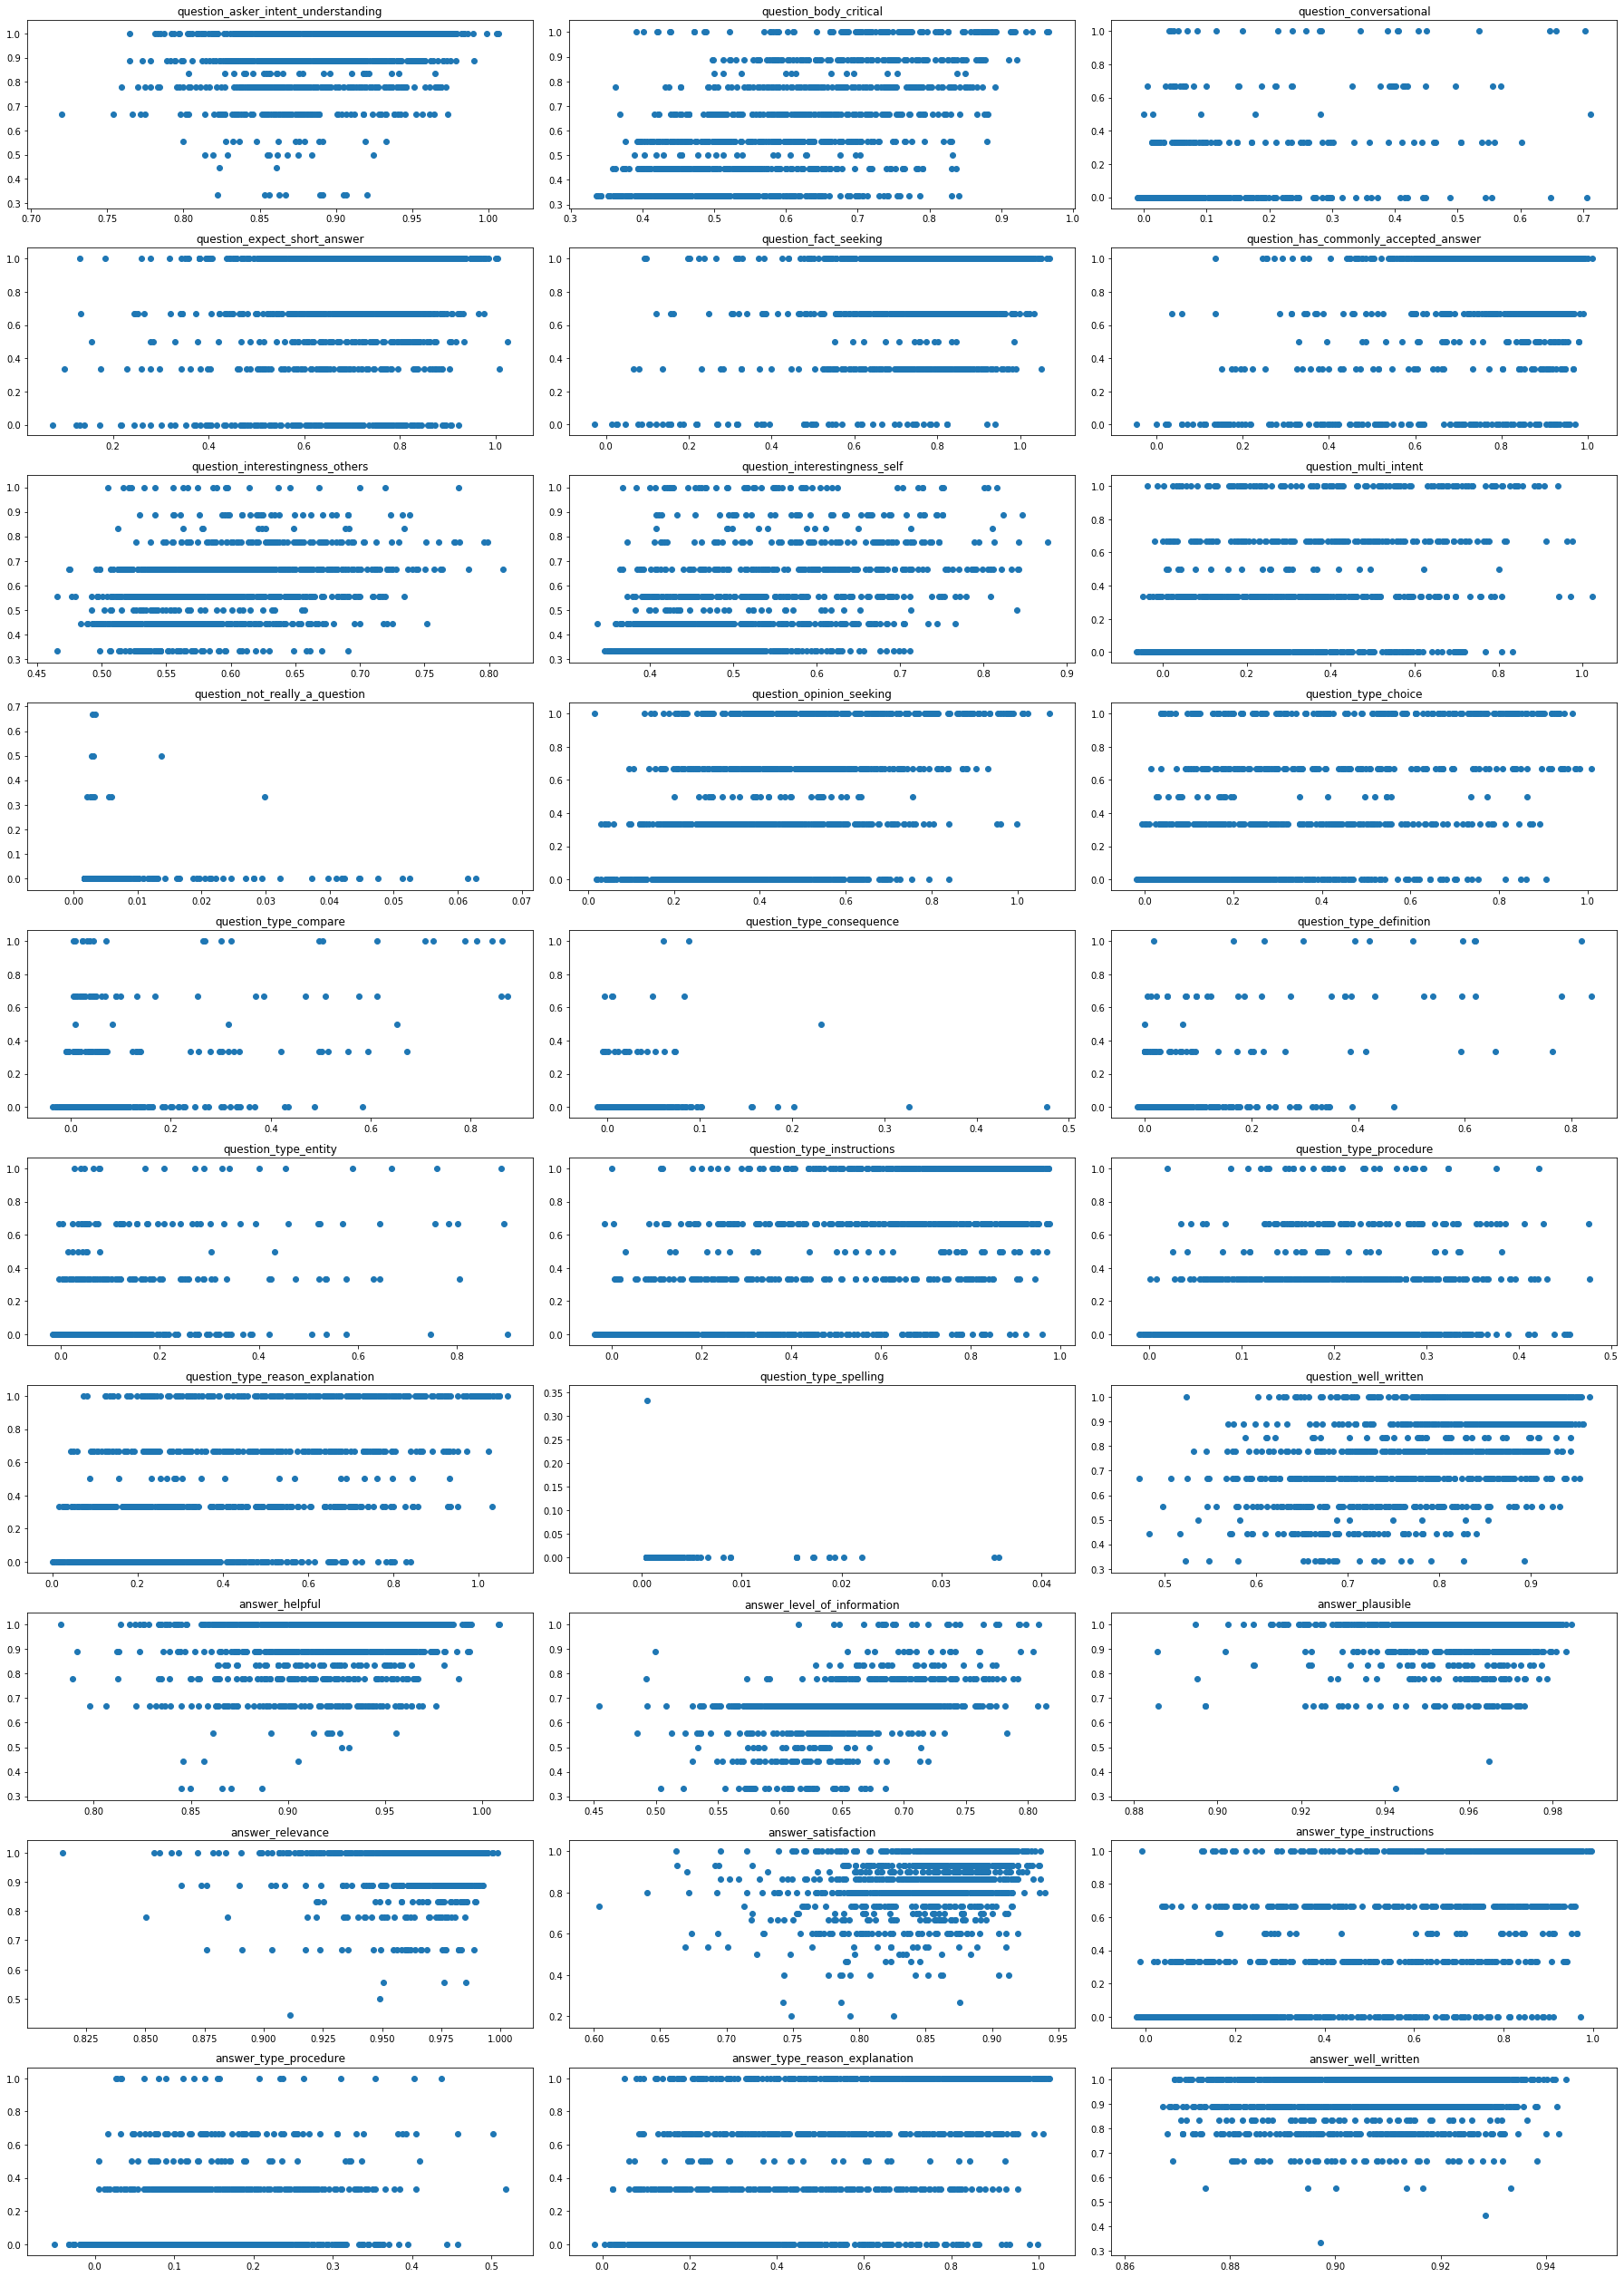

In [27]:
scatterplots(target_names, preds_rf_test, y_test)